In [55]:
MODELS_FROM_FILE = 1

import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.model_selection import StratifiedKFold
from sklearn.model_selection import cross_val_score, cross_val_predict

from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn import svm
from sklearn.linear_model import LogisticRegression

from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler
from sklearn.feature_selection import VarianceThreshold
from sklearn.feature_selection import SelectKBest, mutual_info_classif, f_classif

from sklearn.pipeline import make_pipeline

from sklearn.metrics import confusion_matrix, plot_confusion_matrix, recall_score, precision_score, balanced_accuracy_score, f1_score, roc_auc_score, fbeta_score, make_scorer, roc_curve, precision_recall_curve, accuracy_score
from sklearn.metrics import PrecisionRecallDisplay, ConfusionMatrixDisplay
import matplotlib.pyplot as plt

from sklearn.model_selection import GridSearchCV, RandomizedSearchCV

    
pd.set_option("display.max_columns", None)
pd.set_option('max_colwidth', None)


data_intermediate_dir = "data/intermediate/"
item_lvl_w_imp = pd.read_csv(data_intermediate_dir + "item_lvl_w_impairment.csv")


# Prepare input and ouptut column names

diag_cols = [x for x in item_lvl_w_imp.columns if x.startswith("Diag: ")] # All diagnosis columns

input_cols = [x for x in item_lvl_w_imp.columns if 
                       not x.startswith("Diag: ") 
                       and not x.startswith("WIAT")
                       and not x.startswith("WISC")] # Input columns are all columns except Diagnosis, WIAT, and WISC columns

# Separate test set for all diagnoses

# Shuffle the dataset 
shuffle_df = item_lvl_w_imp.sample(frac=1, random_state=42)

# Define a size for the train set 
train_size = int(0.7 * len(item_lvl_w_imp))

# Split the dataset 
train_set = shuffle_df[:train_size]
test_set = shuffle_df[train_size:] # Don't touch this until the end

# Train_train and Validation set
# Define a size for your train_train set 
train_train_size = int(0.7 * len(train_set))

# Split your dataset 
train_train_set = train_set[:train_train_size]
val_set = train_set[train_train_size:]

In [56]:
def get_base_models_and_param_grids():
    
    # Define base models
    dt = DecisionTreeClassifier()
    rf = RandomForestClassifier()
    svc = svm.SVC()
    lr = LogisticRegression(solver="liblinear")
    
    # Impute missing values
    imputer = SimpleImputer(missing_values=np.nan, strategy='median')
    
    # Standardize data
    scaler = StandardScaler()

    # Make pipelines
    dt_pipe = make_pipeline(imputer, scaler, dt)
    rf_pipe = make_pipeline(imputer, scaler, rf)
    svc_pipe = make_pipeline(imputer, scaler, svc)
    lr_pipe = make_pipeline(imputer, scaler, lr)
    
    # Define parameter grids to search for each pipe
    from scipy.stats import loguniform, uniform
    dt_param_grid = {
        "decisiontreeclassifier__min_samples_split": np.random.randint(2, 20, 30),
        "decisiontreeclassifier__max_depth": np.random.randint(1, 30, 30),
        "decisiontreeclassifier__min_samples_leaf": np.random.randint(1, 20, 30),
        "decisiontreeclassifier__max_leaf_nodes": np.random.randint(2, 50, 30),
        "decisiontreeclassifier__criterion": ['gini', 'entropy'],
        "decisiontreeclassifier__class_weight": ['balanced', None]
    }
    rf_param_grid = {
        'randomforestclassifier__max_depth' : np.random.randint(5, 150, 30),
        'randomforestclassifier__min_samples_split': np.random.randint(2, 50, 30),
        'randomforestclassifier__n_estimators': np.random.randint(50, 400, 10),
        'randomforestclassifier__min_samples_leaf': np.random.randint(1, 20, 30),
        'randomforestclassifier__max_features': ['auto', 'sqrt', 'log2', 0.25, 0.5, 0.75, 1.0],
        'randomforestclassifier__criterion': ['gini', 'entropy'],
        'randomforestclassifier__class_weight':["balanced", "balanced_subsample", None],
        "randomforestclassifier__class_weight": ['balanced', None]
    }
    svc_param_grid = {
        'svc__C': loguniform(1e-03, 1e+02),
        'svc__gamma': loguniform(1e-03, 1e+02),
        'svc__degree': uniform(2, 5),
        'svc__kernel': ['linear', 'poly', 'rbf', 'sigmoid'],
        "svc__class_weight": ['balanced', None]
    }
    lr_param_grid = {
        'logisticregression__C': loguniform(1e-5, 100),
        'logisticregression__penalty': ['l1', 'l2']
    }
    
    base_models_and_param_grids = [
        (dt_pipe, dt_param_grid),
        (rf_pipe, rf_param_grid),
        (svc_pipe, svc_param_grid),
        (lr_pipe, lr_param_grid),
    ]
    
    return base_models_and_param_grids

def get_best_classifier(base_model, grid, output_col):
    cv = StratifiedKFold(n_splits=3)
    rs = RandomizedSearchCV(estimator=base_model, param_distributions=grid, cv=cv, scoring="roc_auc", n_iter=100, n_jobs = -1)
    
    rs.fit(train_set[input_cols], train_set[output_col]) # On train_set, not train_train_set because do cross-validation
    
    best_estimator = rs.best_estimator_
    best_score = rs.best_score_
    
    # If chosen model is SVM add a predict_proba parameter (not needed for grid search, and slows it down significantly)
    if 'svc' in best_estimator.named_steps.keys():
        best_estimator.set_params(svc__probability=True)

    return (best_estimator, best_score)

In [57]:
# Calculate probability threshold
beta = 2.5
def calculate_threshold(classifier, output_col, b = beta):
    from numpy import nanargmax
    
    # Fit model on validation set
    classifier.fit(train_train_set[input_cols], train_train_set[output_col])
    
    # Get predicted probabilities values
    y_val_pred_prob = classifier.predict_proba(val_set[input_cols])
    
    # Calculate precision_recall_curve
    precisions, recalls, thresholds = precision_recall_curve(val_set[output_col], y_val_pred_prob[:,1])
    
    # Calculate F-scores
    fscores = ((1+b**2) * precisions * recalls) / ((b**2 * precisions) + recalls)
    
    # Locate the index of the largest F-score
    ix = nanargmax(fscores)
    
    threshold = thresholds[ix]
    
    return threshold

In [58]:
def find_best_classifier_for_diag(diag):
    best_score = 0
    best_classifier = None
    base_models_and_param_grids = get_base_models_and_param_grids()
    for (base_model, grid) in base_models_and_param_grids:
        best_classifier_for_model, best_score_for_model = get_best_classifier(base_model, grid, diag)
        if best_score_for_model > best_score:
            best_classifier = best_classifier_for_model
            best_score = best_score_for_model
    return best_classifier

In [59]:
if MODELS_FROM_FILE == 0:
    best_classifiers = {}
    for diag in diag_cols:
        if item_lvl_w_imp[diag].sum() > 50: # Don't use diagnoses if there are less than 50 positive examples
            best_classifier_for_diag = find_best_classifier_for_diag(diag)
            threshold = calculate_threshold(best_classifier_for_diag, diag, beta)
            best_classifiers[diag] = (best_classifier_for_diag, threshold)
    print(best_classifiers)

In [67]:
# Find best thresholds
def find_best_thresholds(beta=beta):
    best_thresholds = {}
    for diag in diag_cols:
        if item_lvl_w_imp[diag].sum() > 50: # Don't use diagnoses if there are less than 50 positive examples
            best_classifier_for_diag = best_classifiers[diag][0]
            threshold = calculate_threshold(best_classifier_for_diag, diag, beta)
            best_thresholds[diag] = threshold
    print(best_thresholds)
    return best_thresholds

if MODELS_FROM_FILE == 0:
    best_thresholds = find_best_thresholds(beta=beta)

In [68]:
# REMOVE
best_thresholds = find_best_thresholds(beta=beta)

/var/folders/63/96f7chcx7qq5r9fq4x0x72bw0000gq/T/ipykernel_26837/414853221.py:16: RuntimeWarning: invalid value encountered in true_divide
  fscores = ((1+b**2) * precisions * recalls) / ((b**2 * precisions) + recalls)
/var/folders/63/96f7chcx7qq5r9fq4x0x72bw0000gq/T/ipykernel_26837/414853221.py:16: RuntimeWarning: invalid value encountered in true_divide
  fscores = ((1+b**2) * precisions * recalls) / ((b**2 * precisions) + recalls)
/var/folders/63/96f7chcx7qq5r9fq4x0x72bw0000gq/T/ipykernel_26837/414853221.py:16: RuntimeWarning: invalid value encountered in true_divide
  fscores = ((1+b**2) * precisions * recalls) / ((b**2 * precisions) + recalls)
/var/folders/63/96f7chcx7qq5r9fq4x0x72bw0000gq/T/ipykernel_26837/414853221.py:16: RuntimeWarning: invalid value encountered in true_divide
  fscores = ((1+b**2) * precisions * recalls) / ((b**2 * precisions) + recalls)
/var/folders/63/96f7chcx7qq5r9fq4x0x72bw0000gq/T/ipykernel_26837/414853221.py:16: RuntimeWarning: invalid value encountered 

{'Diag: Enuresis': 0.4802592810842664, 'Diag: Autism Spectrum Disorder': 0.43240122463279884, 'Diag: ADHD-Combined Type': 0.2638237140095848, 'Diag: Specific Learning Disorder with Impairment in Reading': 0.17213264146901136, 'Diag: Generalized Anxiety Disorder': 0.0691692978797863, 'Diag: Specific Learning Disorder with Impairment in Mathematics': 0.18497182011141627, 'Diag: ADHD-Hyperactive/Impulsive Type': 0.2106595297234508, 'Diag: ADHD-Inattentive Type': 0.2312141315043493, 'Diag: Oppositional Defiant Disorder': 0.22654858148953455, 'Diag: Specific Phobia': 0.06919337777783635, 'Diag: Specific Learning Disorder with Impairment in Written Expression': 0.17176660065363097, 'Diag: No Diagnosis Given': 0.5054044921717987, 'Diag: Obsessive-Compulsive Disorder': 0.03021292217291311, 'Diag: Speech Sound Disorder': 0.26483505254679796, 'Diag: Other Specified Anxiety Disorder': 0.04294141417363669, 'Diag: Persistent (Chronic) Motor or Vocal Tic Disorder': 0.08040549307953607, 'Diag: Social

/var/folders/63/96f7chcx7qq5r9fq4x0x72bw0000gq/T/ipykernel_26837/414853221.py:16: RuntimeWarning: invalid value encountered in true_divide
  fscores = ((1+b**2) * precisions * recalls) / ((b**2 * precisions) + recalls)


In [71]:
# REMOVE
dump(best_thresholds, 'best_thresholds.joblib', compress=1)

['best_thresholds.joblib']

In [ ]:
from joblib import dump, load
if MODELS_FROM_FILE == 0:
    # Save best classifiers and thresholds - best parameters, and the classifyer objects themselves
    best_classifiers_df = pd.DataFrame(best_classifiers).T.reset_index()
    best_classifiers_df.columns = ["Diag", "Best Estimator", "Best Threshold"]
    display(best_classifiers_df)
    best_classifiers_df.to_csv("data/output/best-estimators.csv")

    dump(best_classifiers, 'best_classifiers.joblib', compress=1)
    dump(best_thresholds, 'best_thresholds.joblib', compress=1)

In [ ]:
if MODELS_FROM_FILE == 1:
    best_classifiers = load('best_classifiers.joblib')
    best_thresholds = load('best_thresholds.joblib')

In [64]:
import math
metric_names = ['TP','TN','FP','FN','Prevalence','Accuracy','Precision','NPV','FDR','FOR','check_Pos','check_Neg','Recall','FPR','FNR','TNR','check_Pos2','check_Neg2','LR+','LR-','DOR','F1','FBeta','MCC','BM','MK']   
def get_matrix_metrics(real_values,pred_values,beta):
    CM = confusion_matrix(real_values,pred_values)
    TN = CM[0][0]+0.01
    FN = CM[1][0]+0.01
    TP = CM[1][1]+0.01
    FP = CM[0][1]+0.01
    Population = TN+FN+TP+FP
    Prevalence = round( (TP+FP) / Population,2)
    Accuracy   = round( (TP+TN) / Population,4)
    Precision  = round( TP / (TP+FP),4 )
    NPV        = round( TN / (TN+FN),4 )
    FDR        = round( FP / (TP+FP),4 )
    FOR        = round( FN / (TN+FN),4 ) 
    check_Pos  = Precision + FDR
    check_Neg  = NPV + FOR
    Recall     = round( TP / (TP+FN),4 )
    FPR        = round( FP / (TN+FP),4 )
    FNR        = round( FN / (TP+FN),4 )
    TNR        = round( TN / (TN+FP),4 ) 
    check_Pos2 = Recall + FNR
    check_Neg2 = FPR + TNR
    LRPos      = round( Recall/FPR,4 ) 
    LRNeg      = round( FNR / TNR ,4 )
    print("FNR ", FNR, "TNR ", TNR, "FN ", FN, "TP ", TP)
    DOR        = round( LRPos/LRNeg)
    F1         = round ( 2 * ((Precision*Recall)/(Precision+Recall)),4)
    FBeta      = round ( (1+beta**2)*((Precision*Recall)/((beta**2 * Precision)+ Recall)) ,4)
    MCC        = round ( ((TP*TN)-(FP*FN))/math.sqrt((TP+FP)*(TP+FN)*(TN+FP)*(TN+FN))  ,4)
    BM         = Recall+TNR-1
    MK         = Precision+NPV-1   
    
    mat_met = [TP,TN,FP,FN,Prevalence,Accuracy,Precision,NPV,FDR,FOR,check_Pos,check_Neg,Recall,FPR,FNR,TNR,check_Pos2,check_Neg2,LRPos,LRNeg,DOR,F1,FBeta,MCC,BM,MK]
    return (mat_met)

In [65]:
def get_metrics(classifier, threshold, output_col, input_cols, validation_or_test = "validation", print_output_flag = 0):
    input_cols = input_cols
    
    if validation_or_test == "test":
        x = test_set[input_cols]
        y = test_set[output_col]
    else: 
        x = val_set[input_cols]
        y = val_set[output_col]
        
    y_pred_prob = classifier.predict_proba(x)
    y_pred = (y_pred_prob[:,1] >= threshold).astype(bool) 
    
    roc_auc = roc_auc_score(y, y_pred_prob[:,1])
    
    metrics = get_matrix_metrics(y, y_pred, beta=3)
#     {"Recall": recall_score(y, y_pred),
#               "Precision": precision_score(y, y_pred),
#               "F1": f1_score(y, y_pred),
#               "F1_beta": fbeta_score(y, y_pred, beta=3),
#               "Accuracy": accuracy_score(y, y_pred),
#               "ROC_AUC": roc_auc_score(y, y_pred_prob[:,1])}

    metrics.append(roc_auc)
    
    if print_output_flag:
        print(output_col)
        
#         # Print metrics
#         print("Recall: ", recall_score(y, y_pred))
#         print("Precision: ", precision_score(y, y_pred))
#         print("F1: ", f1_score(y, y_pred))
#         print("F1 beta: ", fbeta_score(y, y_pred, beta=3))
#         print("ROC_AUC", roc_auc_score(y, y_pred_prob[:,1]))
        
        # Display confusion matrix
        cm = confusion_matrix(y, y_pred)
        disp = ConfusionMatrixDisplay(confusion_matrix=cm)
        disp.plot()
        plt.show()

        # Display the ROC curve 
        fpr, tpr, thresholds = roc_curve(y, y_pred_prob[:,1])
        plt.plot([0,1], [0,1], linestyle='--', label='No Skill')
        plt.plot(fpr, tpr, marker='.', label='Model')
        plt.xlabel('False Positive Rate')
        plt.ylabel('True Positive Rate')
        plt.legend()
        plt.show()
        
    return metrics

FNR  0.0693 TNR  0.876 FN  2.01 TP  27.01
Diag: Enuresis


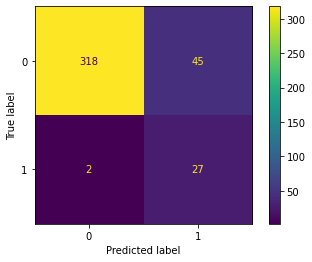

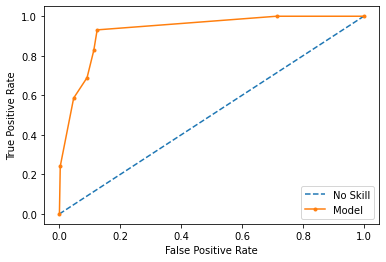

FNR  0.0771 TNR  0.8294 FN  4.01 TP  48.01
Diag: Autism Spectrum Disorder


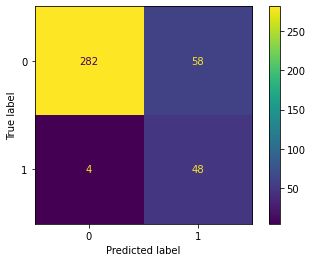

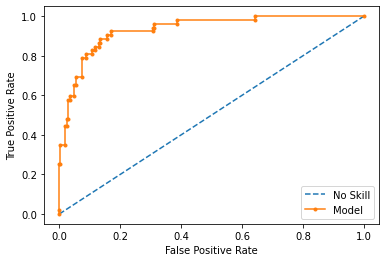

FNR  0.0281 TNR  0.586 FN  3.01 TP  104.01
Diag: ADHD-Combined Type


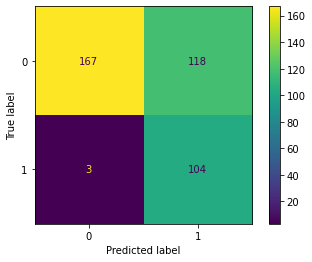

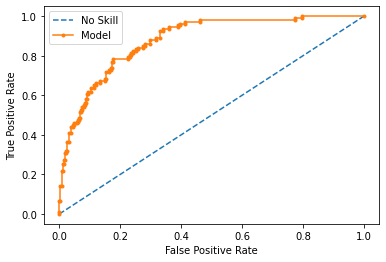

FNR  0.092 TNR  0.3279 FN  8.01 TP  79.01
Diag: Specific Learning Disorder with Impairment in Reading


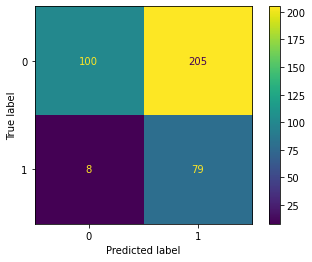

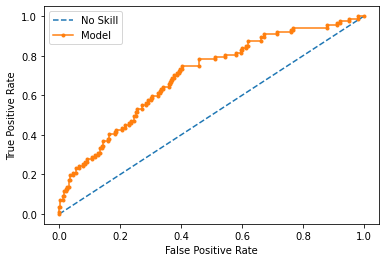

FNR  0.0748 TNR  0.4462 FN  5.01 TP  62.01
Diag: Generalized Anxiety Disorder


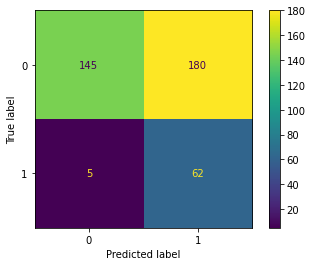

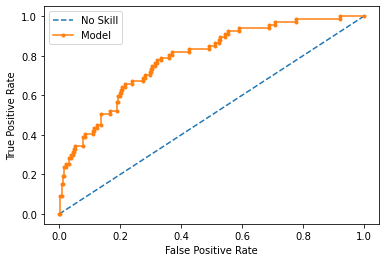

FNR  0.1252 TNR  0.4574 FN  5.01 TP  35.01
Diag: Specific Learning Disorder with Impairment in Mathematics


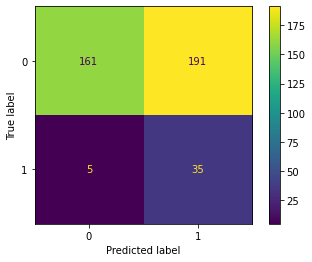

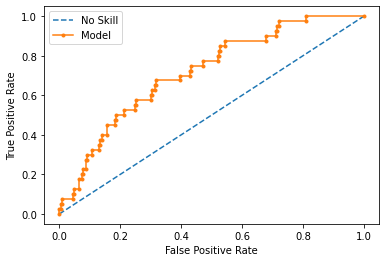

FNR  0.3336 TNR  0.7719 FN  5.01 TP  10.01
Diag: ADHD-Hyperactive/Impulsive Type


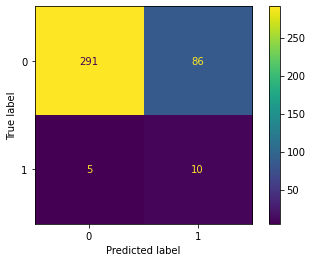

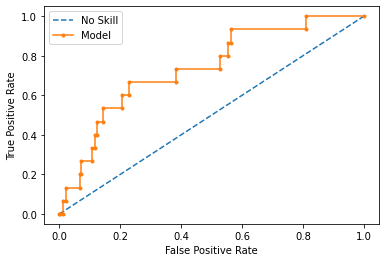

FNR  0.0077 TNR  0.2193 FN  1.01 TP  131.01
Diag: ADHD-Inattentive Type


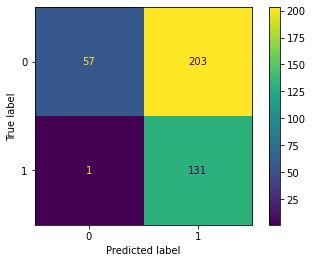

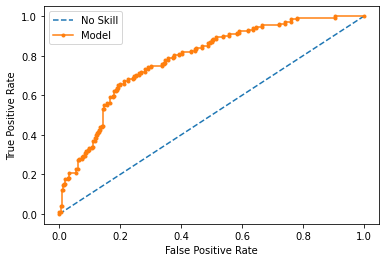

FNR  0.1386 TNR  0.8165 FN  9.01 TP  56.01
Diag: Oppositional Defiant Disorder


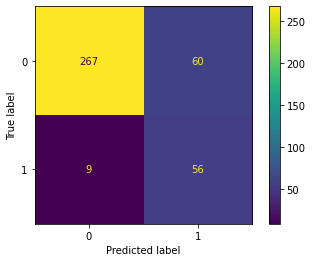

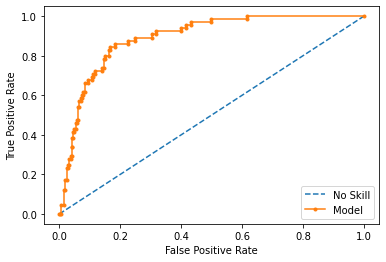

FNR  0.1022 TNR  0.3878 FN  5.01 TP  44.01
Diag: Specific Phobia


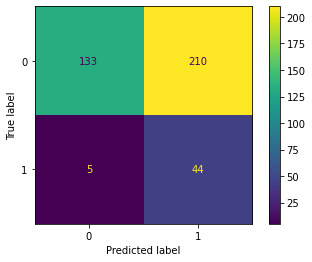

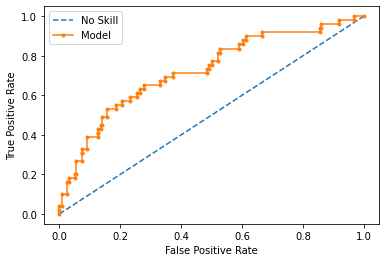

FNR  0.1308 TNR  0.4038 FN  3.01 TP  20.01
Diag: Specific Learning Disorder with Impairment in Written Expression


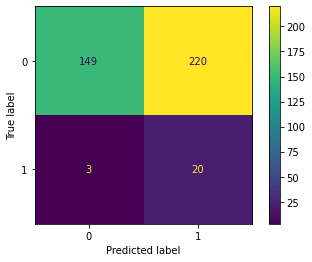

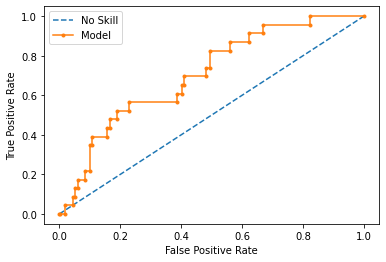

FNR  0.0803 TNR  0.6975 FN  2.01 TP  23.01
Diag: No Diagnosis Given


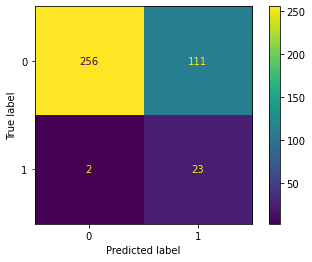

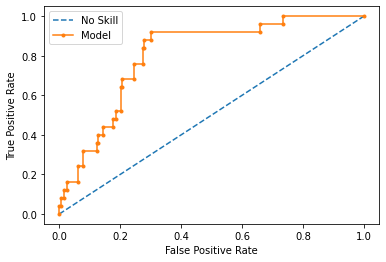

FNR  0.0672 TNR  0.6286 FN  1.01 TP  14.01
Diag: Obsessive-Compulsive Disorder


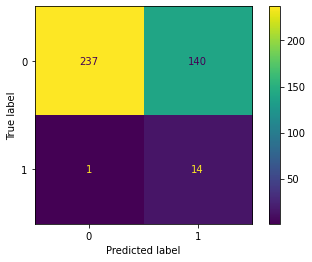

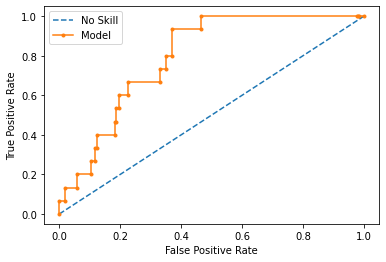

FNR  0.4287 TNR  0.8439 FN  6.01 TP  8.01
Diag: Speech Sound Disorder


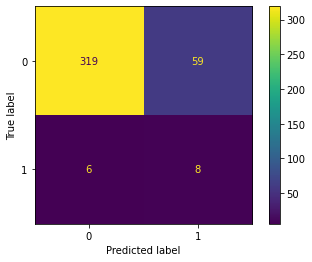

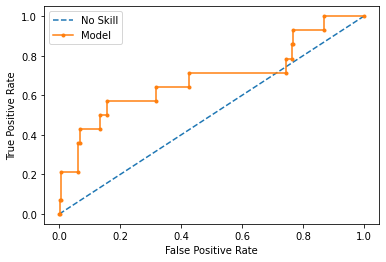

FNR  0.3335 TNR  0.496 FN  7.01 TP  14.01
Diag: Other Specified Anxiety Disorder


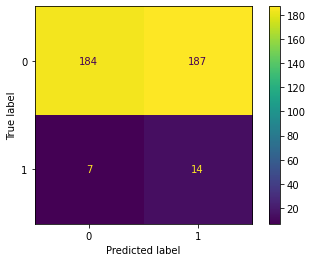

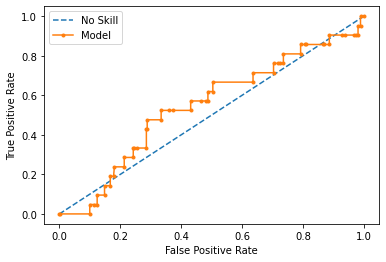

FNR  0.1432 TNR  0.496 FN  3.01 TP  18.01
Diag: Persistent (Chronic) Motor or Vocal Tic Disorder


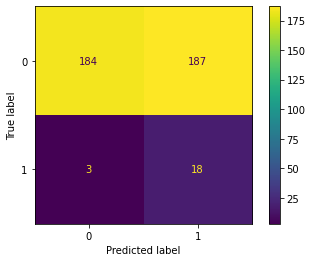

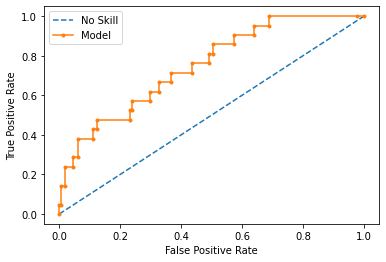

FNR  0.0478 TNR  0.6 FN  2.01 TP  40.01
Diag: Social Anxiety (Social Phobia)


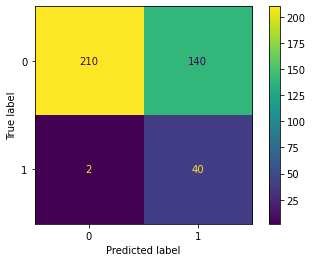

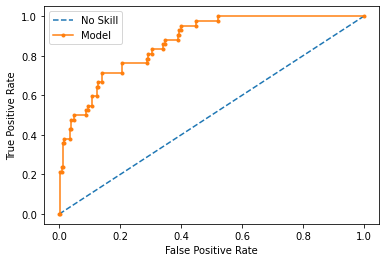

FNR  0.0776 TNR  0.8812 FN  1.01 TP  12.01
Diag: Major Depressive Disorder


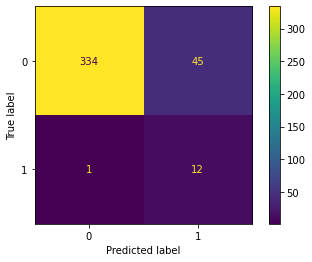

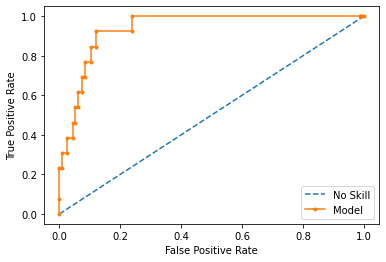

FNR  0.063 TNR  0.3245 FN  1.01 TP  15.01
Diag: Other Specified Attention-Deficit/Hyperactivity Disorder


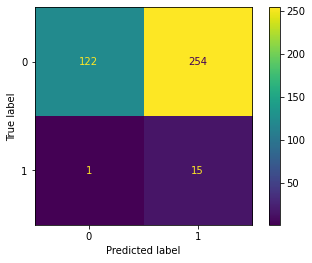

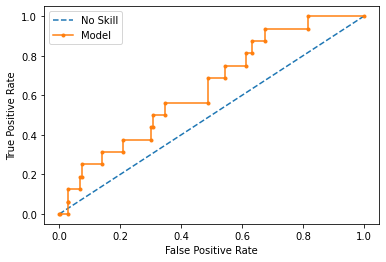

FNR  0.1541 TNR  0.6011 FN  4.01 TP  22.01
Diag: Separation Anxiety


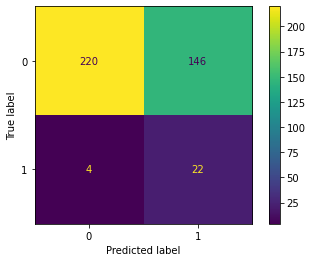

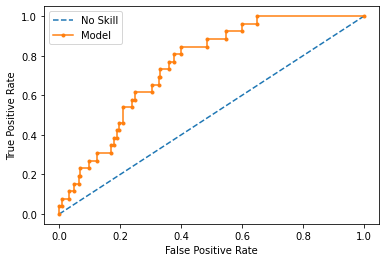

FNR  0.1862 TNR  0.6447 FN  8.01 TP  35.01
Diag: Language Disorder


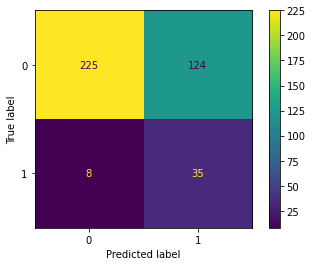

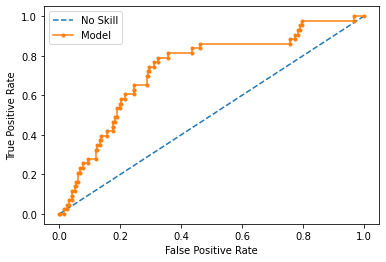

21
28


In [73]:
# Check performance of the final model on validation set for all models

results_val_set = []
for diag in diag_cols:
    if item_lvl_w_imp[diag].sum() > 50:
        classifier = best_classifiers[diag][0]
        threshold = best_thresholds[diag]
        metrics = get_metrics(classifier, threshold, diag, input_cols, 'validation', 1)
        prevalence = item_lvl_w_imp[diag].sum()/len(item_lvl_w_imp)
        results_val_set.append([
            diag, 
            *metrics])
restults_val_set_df = pd.DataFrame(results_val_set, columns=["Diag"]+metric_names+["ROC AUC"])
restults_val_set_df.sort_values(by="ROC AUC", ascending=False)

In [85]:
# Do cross-validation to get more reliable ROC AUC scores (f1 harder to obtain with cross validation - need to change threshold)

auc_cv_mean_val_set = []
auc_cv_std_val_set = []
for diag in diag_cols:
    if item_lvl_w_imp[diag].sum() > 50:
        classifier = best_classifiers[diag][0]
        
        cv = StratifiedKFold(n_splits=5)
        auc = cross_val_score(classifier, train_set[input_cols], train_set[diag], cv=cv, scoring='roc_auc', n_jobs=-1)
        
        auc_cv_mean_val_set.append(auc.mean())
        auc_cv_std_val_set.append(auc.std())
restults_val_set_df["ROC AUC Mean CV"] = pd.Series(auc_cv_mean_val_set)
restults_val_set_df["ROC AUC Std CV"] = pd.Series(auc_cv_std_val_set)
restults_val_set_df

,Diag,TP,TN,FP,FN,Prevalence,Accuracy,Precision,NPV,FDR,FOR,check_Pos,check_Neg,Recall,FPR,FNR,TNR,check_Pos2,check_Neg2,LR+,LR-,DOR,F1,FBeta,MCC,BM,MK,ROC AUC,ROC AUC Mean CV,ROC AUC Std CV
0,Diag: Enuresis,27.01,318.01,45.01,2.01,0.18,0.8801,0.3750,0.9937,0.6250,0.0063,1.0,1.0,0.9307,0.1240,0.0693,0.8760,1.0,1.0,7.5056,0.0791,95,0.5346,0.8106,0.5454,0.8067,0.3687,0.928802,0.900488,0.030757
1,Diag: Autism Spectrum Disorder,48.01,282.01,58.01,4.01,0.27,0.8418,0.4528,0.9860,0.5472,0.0140,1.0,1.0,0.9229,0.1706,0.0771,0.8294,1.0,1.0,5.4097,0.0930,58,0.6075,0.8361,0.5746,0.7523,0.4388,0.932805,0.906784,0.019334
2,Diag: ADHD-Combined Type,104.01,167.01,118.01,3.01,0.57,0.6913,0.4685,0.9823,0.5315,0.0177,1.0,1.0,0.9719,0.4140,0.0281,0.5860,1.0,1.0,2.3476,0.0480,49,0.6322,0.8776,0.5015,0.5579,0.4508,0.879784,0.864003,0.025738
3,Diag: Specific Learning Disorder with Impairment in Reading,79.01,100.01,205.01,8.01,0.72,0.4566,0.2782,0.9258,0.7218,0.0742,1.0,1.0,0.9080,0.6721,0.0920,0.3279,1.0,1.0,1.3510,0.2806,5,0.4259,0.7404,0.2194,0.2359,0.2040,0.698361,0.673640,0.023582
4,Diag: Generalized Anxiety Disorder,62.01,145.01,180.01,5.01,0.62,0.5281,0.2562,0.9666,0.7438,0.0334,1.0,1.0,0.9252,0.5538,0.0748,0.4462,1.0,1.0,1.6706,0.1676,10,0.4013,0.7336,0.2877,0.3714,0.2228,0.787876,0.835389,0.034962
5,Diag: Specific Learning Disorder with Impairment in Mathematics,35.01,161.01,191.01,5.01,0.58,0.5000,0.1549,0.9698,0.8451,0.0302,1.0,1.0,0.8748,0.5426,0.1252,0.4574,1.0,1.0,1.6122,0.2737,6,0.2632,0.5972,0.2035,0.3322,0.1247,0.718040,0.716678,0.039212
6,Diag: ADHD-Hyperactive/Impulsive Type,10.01,291.01,86.01,5.01,0.24,0.7678,0.1042,0.9831,0.8958,0.0169,1.0,1.0,0.6664,0.2281,0.3336,0.7719,1.0,1.0,2.9215,0.4322,7,0.1802,0.4329,0.1956,0.4383,0.0873,0.737754,0.804546,0.061809
7,Diag: ADHD-Inattentive Type,131.01,57.01,203.01,1.01,0.85,0.4796,0.3922,0.9826,0.6078,0.0174,1.0,1.0,0.9923,0.7807,0.0077,0.2193,1.0,1.0,1.2710,0.0351,36,0.5622,0.8606,0.2816,0.2116,0.3748,0.784266,0.772170,0.020222
8,Diag: Oppositional Defiant Disorder,56.01,267.01,60.01,9.01,0.30,0.8239,0.4828,0.9674,0.5172,0.0326,1.0,1.0,0.8614,0.1835,0.1386,0.8165,1.0,1.0,4.6943,0.1697,28,0.6188,0.7988,0.5524,0.6779,0.4502,0.891367,0.876541,0.017310
9,Diag: Specific Phobia,44.01,133.01,210.01,5.01,0.65,0.4515,0.1733,0.9637,0.8267,0.0363,1.0,1.0,0.8978,0.6122,0.1022,0.3878,1.0,1.0,1.4665,0.2635,6,0.2905,0.6331,0.1978,0.2856,0.1370,0.726245,0.693047,0.045134


FNR  0.1965 TNR  0.8928 FN  11.01 TP  45.01
Diag: Enuresis


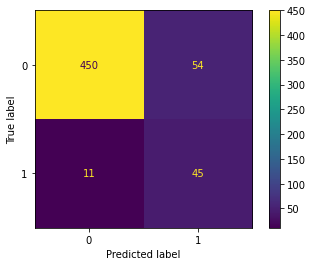

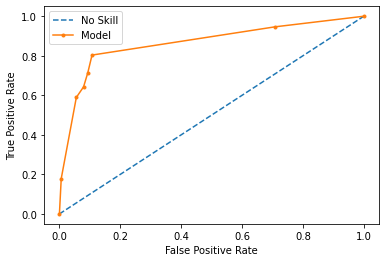

FNR  0.1686 TNR  0.7983 FN  15.01 TP  74.01
Diag: Autism Spectrum Disorder


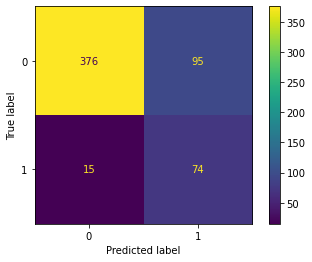

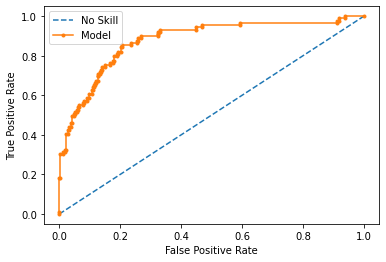

FNR  0.0774 TNR  0.5893 FN  13.01 TP  155.01
Diag: ADHD-Combined Type


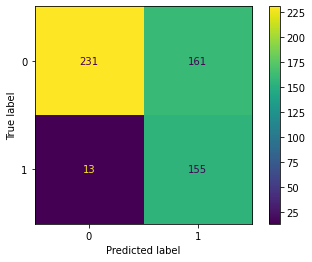

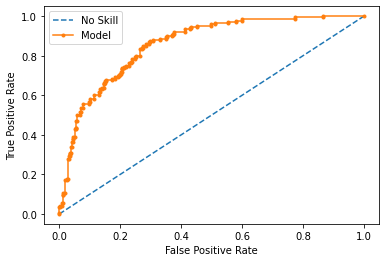

FNR  0.192 TNR  0.3287 FN  24.01 TP  101.01
Diag: Specific Learning Disorder with Impairment in Reading


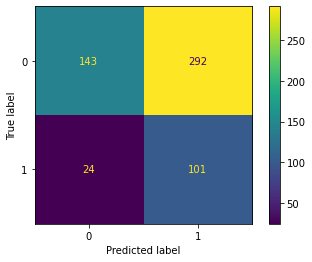

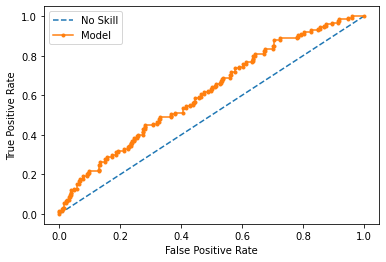

FNR  0.011 TNR  0.4231 FN  1.01 TP  91.01
Diag: Generalized Anxiety Disorder


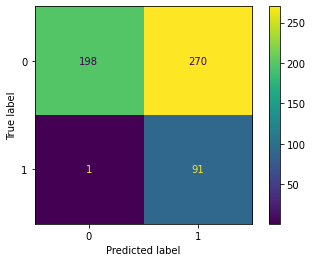

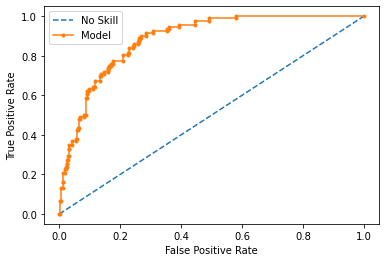

FNR  0.113 TNR  0.4036 FN  7.01 TP  55.01
Diag: Specific Learning Disorder with Impairment in Mathematics


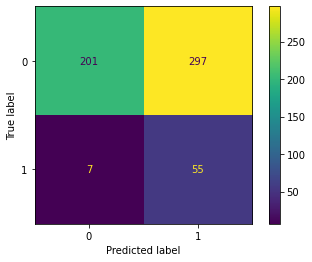

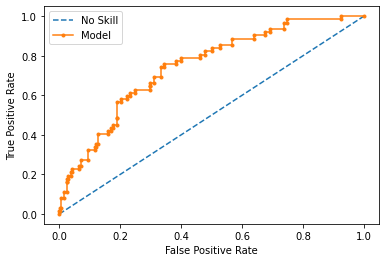

FNR  0.084 TNR  0.7701 FN  1.01 TP  11.01
Diag: ADHD-Hyperactive/Impulsive Type


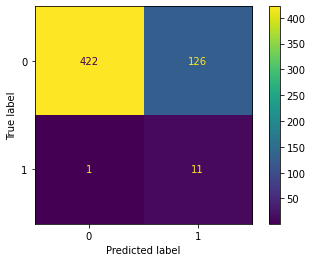

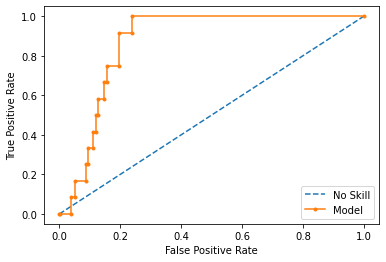

FNR  0.0059 TNR  0.2088 FN  1.01 TP  171.01
Diag: ADHD-Inattentive Type


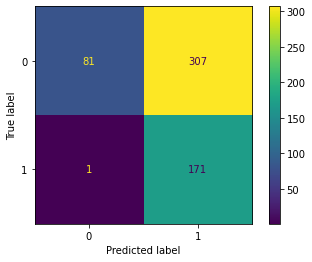

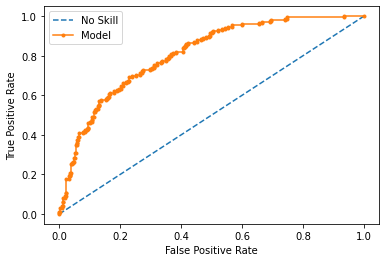

FNR  0.1861 TNR  0.7848 FN  16.01 TP  70.01
Diag: Oppositional Defiant Disorder


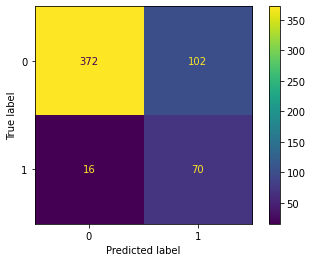

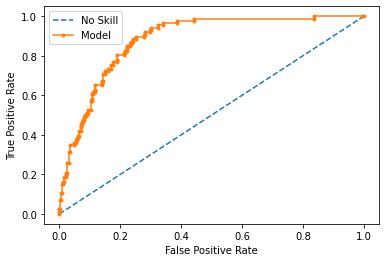

FNR  0.0783 TNR  0.375 FN  5.01 TP  59.01
Diag: Specific Phobia


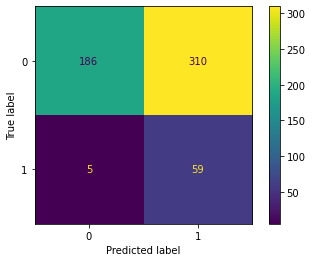

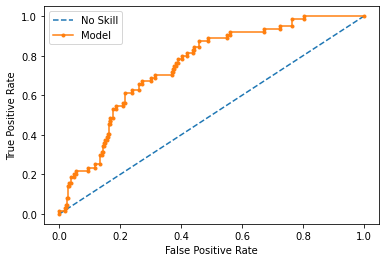

FNR  0.245 TNR  0.3973 FN  12.01 TP  37.01
Diag: Specific Learning Disorder with Impairment in Written Expression


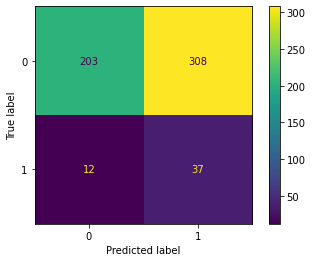

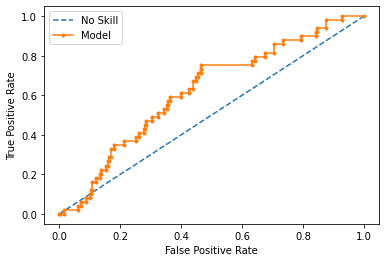

FNR  0.2668 TNR  0.7264 FN  8.01 TP  22.01
Diag: No Diagnosis Given


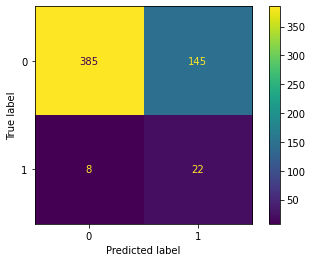

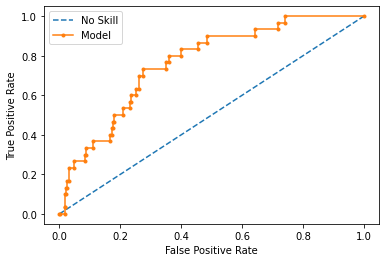

FNR  0.2228 TNR  0.6025 FN  2.01 TP  7.01
Diag: Obsessive-Compulsive Disorder


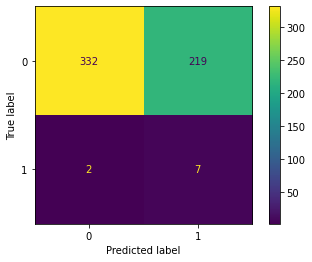

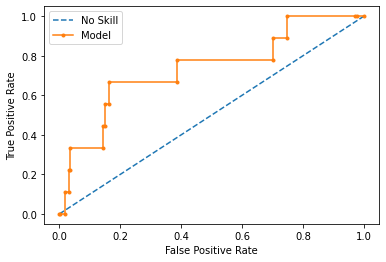

FNR  0.4287 TNR  0.8571 FN  6.01 TP  8.01
Diag: Speech Sound Disorder


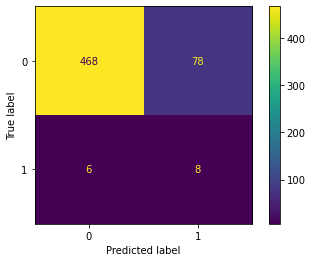

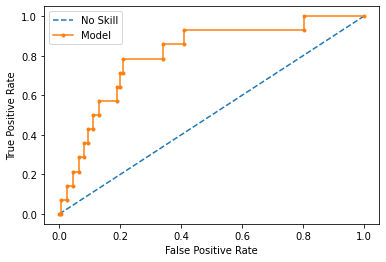

FNR  0.3914 TNR  0.4916 FN  9.01 TP  14.01
Diag: Other Specified Anxiety Disorder


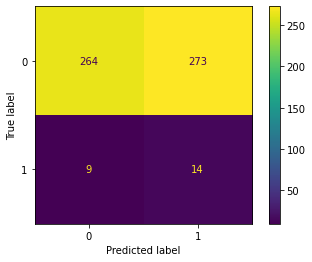

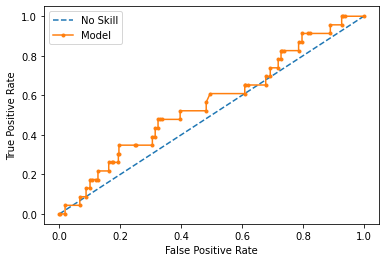

FNR  0.1115 TNR  0.4557 FN  2.01 TP  16.01
Diag: Persistent (Chronic) Motor or Vocal Tic Disorder


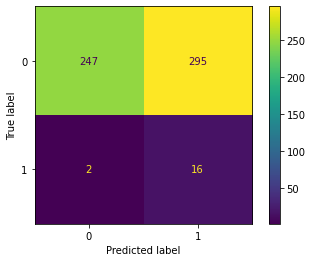

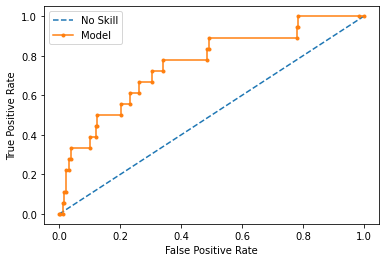

FNR  0.0939 TNR  0.5766 FN  6.01 TP  58.01
Diag: Social Anxiety (Social Phobia)


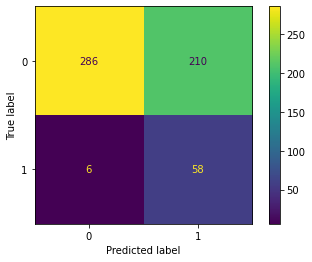

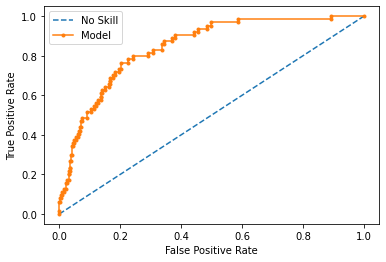

FNR  0.1767 TNR  0.8631 FN  6.01 TP  28.01
Diag: Major Depressive Disorder


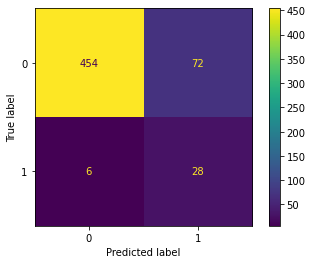

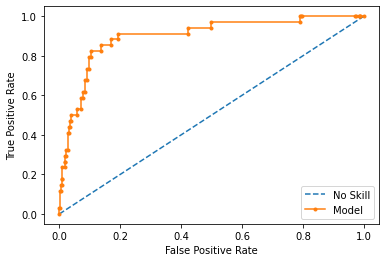

FNR  0.2416 TNR  0.3484 FN  7.01 TP  22.01
Diag: Other Specified Attention-Deficit/Hyperactivity Disorder


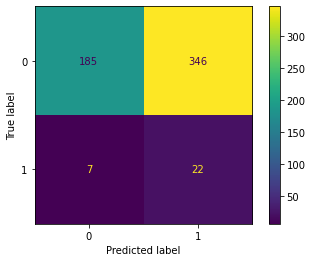

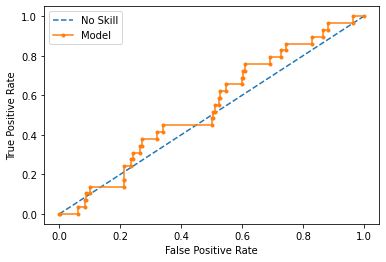

FNR  0.1028 TNR  0.6238 FN  4.01 TP  35.01
Diag: Separation Anxiety


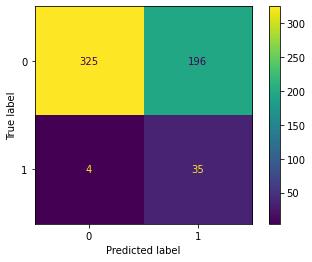

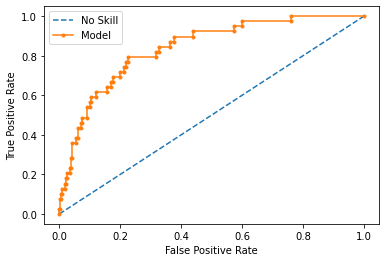

FNR  0.2437 TNR  0.6577 FN  19.01 TP  59.01
Diag: Language Disorder


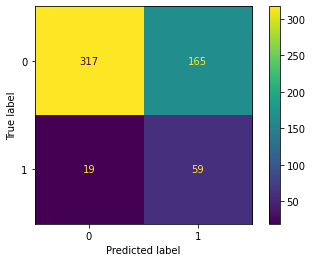

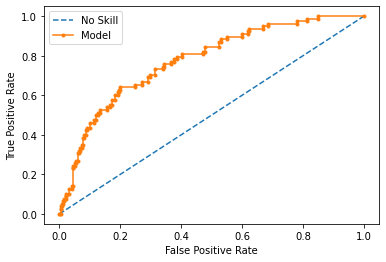

TypeError: 'DataFrame' object is not callable

In [93]:
# Check performance of the final model on test set for all models

results_test_set = []
for diag in diag_cols:
    if item_lvl_w_imp[diag].sum() > 50:
        classifier = best_classifiers[diag][0]
        threshold = best_thresholds[diag]
        metrics = get_metrics(classifier, threshold, diag, input_cols, 'test', 1)
        prevalence = item_lvl_w_imp[diag].sum()/len(item_lvl_w_imp)
        results_test_set.append([
            diag, 
            *metrics])
restults_test_set_df = pd.DataFrame(results_test_set, columns=["Diag"]+metric_names+["ROC AUC"])
restults_test_set_df(by="ROC AUC", ascending=False)

### Feature importance

In [98]:
# Only use well performing diagnoses for feature selection: with (Mean CV AUC - Mean CV Std) > 0.65 and F1 Beta > 0.5

diags_with_good_performance = list(restults_val_set_df[((restults_val_set_df["ROC AUC Mean CV"] - restults_val_set_df["ROC AUC Std CV"])>0.65) & (restults_val_set_df["FBeta"] > 0.5)]["Diag"])
display(diags_with_good_performance)
len(diags_with_good_performance)

['Diag: Enuresis',
 'Diag: Autism Spectrum Disorder',
 'Diag: ADHD-Combined Type',
 'Diag: Specific Learning Disorder with Impairment in Reading',
 'Diag: Generalized Anxiety Disorder',
 'Diag: Specific Learning Disorder with Impairment in Mathematics',
 'Diag: ADHD-Inattentive Type',
 'Diag: Oppositional Defiant Disorder',
 'Diag: No Diagnosis Given',
 'Diag: Social Anxiety (Social Phobia)',
 'Diag: Major Depressive Disorder',
 'Diag: Separation Anxiety',
 'Diag: Language Disorder']

13

In [99]:
def get_feature_importances(classifier):
    # Different feature importances method for linear models and tree models
    if 'logisticregression' in classifier.named_steps.keys() or ('svc' in classifier.named_steps.keys() and classifier.get_params()['svc__kernel'] == "linear"):
        importances = classifier._final_estimator.coef_
        feature_importances = pd.DataFrame(data={
                                "Importance": abs(importances[0]),
                                "Feature": input_cols
                            }).sort_values(by="Importance", ascending=False)
    elif "randomforestclassifier" in classifier.named_steps.keys() or "decisiontreeclassifier" in classifier.named_steps.keys():
        importances = classifier._final_estimator.feature_importances_
        feature_importances = pd.DataFrame(zip(input_cols, importances), columns=["Feature", "Importance"]).sort_values(by="Importance", ascending=False)
    display(feature_importances)
    return feature_importances

In [100]:
# Get feature importances from models

from sklearn.base import clone
for diag in diags_with_good_performance:
    print(diag)
    diag_classifier_all_features = best_classifiers[diag][0] 
    
    # Only do this if classifier is not non-linear SVM (impossible to obtain feature importances)
    if 'svc' not in diag_classifier_all_features.named_steps.keys() or ('svc' in diag_classifier_all_features.named_steps.keys() and diag_classifier_all_features._final_estimator.get_params()['kernel'] == "linear"):
        
        threshold = best_classifiers[diag][1]
        feature_importances = get_feature_importances(diag_classifier_all_features)
        display(feature_importances)
        
        # Append feature importances to the dictionary of classifiers per diagnosis
        best_classifiers[diag] = (best_classifiers[diag][0], best_classifiers[diag][1], feature_importances)

Diag: Enuresis


,Feature,Importance
336,"CBCL,CBCL_108",0.667538
57,"SympChck,CSC_28P",0.214549
755,"PSI,PSI_PD",0.081713
802,"PhenX_Neighborhood,PhenX_NS_02",0.018101
591,"ESWAN,Panic_B05",0.018098
...,...,...
286,"SRS,SRS_33",0.000000
287,"SRS,SRS_34",0.000000
288,"SRS,SRS_35",0.000000
289,"SRS,SRS_36",0.000000


,Feature,Importance
336,"CBCL,CBCL_108",0.667538
57,"SympChck,CSC_28P",0.214549
755,"PSI,PSI_PD",0.081713
802,"PhenX_Neighborhood,PhenX_NS_02",0.018101
591,"ESWAN,Panic_B05",0.018098
...,...,...
286,"SRS,SRS_33",0.000000
287,"SRS,SRS_34",0.000000
288,"SRS,SRS_35",0.000000
289,"SRS,SRS_36",0.000000


Diag: Autism Spectrum Disorder


,Importance,Feature
138,0.092872,"SCQ,SCQ_11"
305,0.065040,"SRS,SRS_53"
142,0.051200,"SCQ,SCQ_15"
103,0.048456,"SympChck,CSC_51P"
192,0.047176,"ASSQ,ASSQ_24"
...,...,...
125,0.000000,"SympChck,CSC_55hP"
118,0.000000,"SympChck,CSC_55eC"
121,0.000000,"SympChck,CSC_55fP"
122,0.000000,"SympChck,CSC_55gC"


,Importance,Feature
138,0.092872,"SCQ,SCQ_11"
305,0.065040,"SRS,SRS_53"
142,0.051200,"SCQ,SCQ_15"
103,0.048456,"SympChck,CSC_51P"
192,0.047176,"ASSQ,ASSQ_24"
...,...,...
125,0.000000,"SympChck,CSC_55hP"
118,0.000000,"SympChck,CSC_55eC"
121,0.000000,"SympChck,CSC_55fP"
122,0.000000,"SympChck,CSC_55gC"


Diag: ADHD-Combined Type


,Feature,Importance
251,"SWAN,SWAN_16",0.206224
327,"CBCL,CBCL_10",0.045095
73,"SympChck,CSC_36P",0.042420
253,"SWAN,SWAN_18",0.039539
245,"SWAN,SWAN_10",0.032079
...,...,...
392,"CBCL,CBCL_56G",0.000000
393,"CBCL,CBCL_56H",0.000000
396,"CBCL,CBCL_59",0.000000
195,"ASSQ,ASSQ_27",0.000000


,Feature,Importance
251,"SWAN,SWAN_16",0.206224
327,"CBCL,CBCL_10",0.045095
73,"SympChck,CSC_36P",0.042420
253,"SWAN,SWAN_18",0.039539
245,"SWAN,SWAN_10",0.032079
...,...,...
392,"CBCL,CBCL_56G",0.000000
393,"CBCL,CBCL_56H",0.000000
396,"CBCL,CBCL_59",0.000000
195,"ASSQ,ASSQ_27",0.000000


Diag: Specific Learning Disorder with Impairment in Reading


,Feature,Importance
736,"PSI,PSI_18",0.030329
654,"APQ_SR,APQ_SR_11",0.018762
0,"Basic_Demos,Age",0.013607
816,"WHODAS_SR,WHODAS_SR_Days01",0.010050
274,"SRS,SRS_21",0.008926
...,...,...
108,"SympChck,CSC_54C",0.000000
107,"SympChck,CSC_53P",0.000000
106,"SympChck,CSC_53C",0.000000
287,"SRS,SRS_34",0.000000


,Feature,Importance
736,"PSI,PSI_18",0.030329
654,"APQ_SR,APQ_SR_11",0.018762
0,"Basic_Demos,Age",0.013607
816,"WHODAS_SR,WHODAS_SR_Days01",0.010050
274,"SRS,SRS_21",0.008926
...,...,...
108,"SympChck,CSC_54C",0.000000
107,"SympChck,CSC_53P",0.000000
106,"SympChck,CSC_53C",0.000000
287,"SRS,SRS_34",0.000000


Diag: Generalized Anxiety Disorder


,Feature,Importance
210,"SDQ,SDQ_08",0.293392
46,"SympChck,CSC_23C",0.085364
0,"Basic_Demos,Age",0.057524
341,"CBCL,CBCL_112",0.033321
583,"ESWAN,Panic_A02A",0.029724
...,...,...
145,"SCQ,SCQ_18",0.000000
146,"SCQ,SCQ_19",0.000000
147,"SCQ,SCQ_20",0.000000
148,"SCQ,SCQ_21",0.000000


,Feature,Importance
210,"SDQ,SDQ_08",0.293392
46,"SympChck,CSC_23C",0.085364
0,"Basic_Demos,Age",0.057524
341,"CBCL,CBCL_112",0.033321
583,"ESWAN,Panic_A02A",0.029724
...,...,...
145,"SCQ,SCQ_18",0.000000
146,"SCQ,SCQ_19",0.000000
147,"SCQ,SCQ_20",0.000000
148,"SCQ,SCQ_21",0.000000


Diag: Specific Learning Disorder with Impairment in Mathematics


,Feature,Importance
0,"Basic_Demos,Age",0.095820
736,"PSI,PSI_18",0.042574
241,"SWAN,SWAN_06",0.026687
818,"WHODAS_SR,WHODAS_SR_Days03",0.026289
237,"SWAN,SWAN_02",0.015600
...,...,...
621,"MFQ_P,MFQ_P_16",0.000000
199,"ARI_P,ARI_P_04",0.000000
618,"MFQ_P,MFQ_P_13",0.000000
615,"MFQ_P,MFQ_P_10",0.000000


,Feature,Importance
0,"Basic_Demos,Age",0.095820
736,"PSI,PSI_18",0.042574
241,"SWAN,SWAN_06",0.026687
818,"WHODAS_SR,WHODAS_SR_Days03",0.026289
237,"SWAN,SWAN_02",0.015600
...,...,...
621,"MFQ_P,MFQ_P_16",0.000000
199,"ARI_P,ARI_P_04",0.000000
618,"MFQ_P,MFQ_P_13",0.000000
615,"MFQ_P,MFQ_P_10",0.000000


Diag: ADHD-Inattentive Type


,Feature,Importance
239,"SWAN,SWAN_04",0.027294
240,"SWAN,SWAN_05",0.026220
578,"ESWAN,MDD_8A",0.025746
325,"CBCL,CBCL_08",0.020915
0,"Basic_Demos,Age",0.017747
...,...,...
50,"SympChck,CSC_25C",0.000000
607,"MFQ_P,MFQ_P_02",0.000000
48,"SympChck,CSC_24C",0.000000
133,"SCQ,SCQ_06",0.000000


,Feature,Importance
239,"SWAN,SWAN_04",0.027294
240,"SWAN,SWAN_05",0.026220
578,"ESWAN,MDD_8A",0.025746
325,"CBCL,CBCL_08",0.020915
0,"Basic_Demos,Age",0.017747
...,...,...
50,"SympChck,CSC_25C",0.000000
607,"MFQ_P,MFQ_P_02",0.000000
48,"SympChck,CSC_24C",0.000000
133,"SCQ,SCQ_06",0.000000


Diag: Oppositional Defiant Disorder


,Feature,Importance
79,"SympChck,CSC_39P",0.019709
78,"SympChck,CSC_39C",0.018461
352,"CBCL,CBCL_22",0.015552
753,"PSI,PSI_35",0.015009
320,"CBCL,CBCL_03",0.014403
...,...,...
397,"CBCL,CBCL_60",0.000000
404,"CBCL,CBCL_67",0.000000
407,"CBCL,CBCL_70",0.000000
409,"CBCL,CBCL_72",0.000000


,Feature,Importance
79,"SympChck,CSC_39P",0.019709
78,"SympChck,CSC_39C",0.018461
352,"CBCL,CBCL_22",0.015552
753,"PSI,PSI_35",0.015009
320,"CBCL,CBCL_03",0.014403
...,...,...
397,"CBCL,CBCL_60",0.000000
404,"CBCL,CBCL_67",0.000000
407,"CBCL,CBCL_70",0.000000
409,"CBCL,CBCL_72",0.000000


Diag: No Diagnosis Given


,Importance,Feature
578,0.005750,"ESWAN,MDD_8A"
71,0.005051,"SympChck,CSC_35P"
217,0.005008,"SDQ,SDQ_15"
69,0.004906,"SympChck,CSC_34P"
415,0.004653,"CBCL,CBCL_78"
...,...,...
125,0.000000,"SympChck,CSC_55hP"
122,0.000000,"SympChck,CSC_55gC"
121,0.000000,"SympChck,CSC_55fP"
120,0.000000,"SympChck,CSC_55fC"


,Importance,Feature
578,0.005750,"ESWAN,MDD_8A"
71,0.005051,"SympChck,CSC_35P"
217,0.005008,"SDQ,SDQ_15"
69,0.004906,"SympChck,CSC_34P"
415,0.004653,"CBCL,CBCL_78"
...,...,...
125,0.000000,"SympChck,CSC_55hP"
122,0.000000,"SympChck,CSC_55gC"
121,0.000000,"SympChck,CSC_55fP"
120,0.000000,"SympChck,CSC_55fC"


Diag: Social Anxiety (Social Phobia)


,Feature,Importance
412,"CBCL,CBCL_75",0.025725
41,"SympChck,CSC_20P",0.022347
40,"SympChck,CSC_20C",0.022269
256,"SRS,SRS_03",0.017874
0,"Basic_Demos,Age",0.012149
...,...,...
111,"SympChck,CSC_55aP",0.000000
110,"SympChck,CSC_55aC",0.000000
109,"SympChck,CSC_54P",0.000000
108,"SympChck,CSC_54C",0.000000


,Feature,Importance
412,"CBCL,CBCL_75",0.025725
41,"SympChck,CSC_20P",0.022347
40,"SympChck,CSC_20C",0.022269
256,"SRS,SRS_03",0.017874
0,"Basic_Demos,Age",0.012149
...,...,...
111,"SympChck,CSC_55aP",0.000000
110,"SympChck,CSC_55aC",0.000000
109,"SympChck,CSC_54P",0.000000
108,"SympChck,CSC_54C",0.000000


Diag: Major Depressive Disorder


,Feature,Importance
3,"SympChck,CSC_01P",0.234718
0,"Basic_Demos,Age",0.179407
709,"CIS_P,CIS_P_04",0.047514
215,"SDQ,SDQ_13",0.027060
331,"CBCL,CBCL_103",0.018668
...,...,...
322,"CBCL,CBCL_05",0.000000
323,"CBCL,CBCL_06",0.000000
324,"CBCL,CBCL_07",0.000000
325,"CBCL,CBCL_08",0.000000


,Feature,Importance
3,"SympChck,CSC_01P",0.234718
0,"Basic_Demos,Age",0.179407
709,"CIS_P,CIS_P_04",0.047514
215,"SDQ,SDQ_13",0.027060
331,"CBCL,CBCL_103",0.018668
...,...,...
322,"CBCL,CBCL_05",0.000000
323,"CBCL,CBCL_06",0.000000
324,"CBCL,CBCL_07",0.000000
325,"CBCL,CBCL_08",0.000000


Diag: Separation Anxiety


,Importance,Feature
713,0.222992,"CIS_P,CIS_P_08"
33,0.207953,"SympChck,CSC_16P"
36,0.199891,"SympChck,CSC_18C"
26,0.180228,"SympChck,CSC_13C"
127,0.157378,"SympChck,CSC_55iP"
...,...,...
297,0.000000,"SRS,SRS_44"
298,0.000000,"SRS,SRS_45"
299,0.000000,"SRS,SRS_47"
300,0.000000,"SRS,SRS_48"


,Importance,Feature
713,0.222992,"CIS_P,CIS_P_08"
33,0.207953,"SympChck,CSC_16P"
36,0.199891,"SympChck,CSC_18C"
26,0.180228,"SympChck,CSC_13C"
127,0.157378,"SympChck,CSC_55iP"
...,...,...
297,0.000000,"SRS,SRS_44"
298,0.000000,"SRS,SRS_45"
299,0.000000,"SRS,SRS_47"
300,0.000000,"SRS,SRS_48"


Diag: Language Disorder


,Feature,Importance
736,"PSI,PSI_18",0.039829
755,"PSI,PSI_PD",0.023729
416,"CBCL,CBCL_79",0.023125
685,"APQ_SR,APQ_SR_37",0.017328
726,"PSI,PSI_08",0.013966
...,...,...
115,"SympChck,CSC_55cP",0.000000
142,"SCQ,SCQ_15",0.000000
192,"ASSQ,ASSQ_24",0.000000
195,"ASSQ,ASSQ_27",0.000000


,Feature,Importance
736,"PSI,PSI_18",0.039829
755,"PSI,PSI_PD",0.023729
416,"CBCL,CBCL_79",0.023125
685,"APQ_SR,APQ_SR_37",0.017328
726,"PSI,PSI_08",0.013966
...,...,...
115,"SympChck,CSC_55cP",0.000000
142,"SCQ,SCQ_15",0.000000
192,"ASSQ,ASSQ_24",0.000000
195,"ASSQ,ASSQ_27",0.000000


In [105]:
# From here only learning diagnoses for now, computationnaly expensive to do others
learning_diag_with_good_performance = ['Diag: Specific Learning Disorder with Impairment in Mathematics', 'Diag: Specific Learning Disorder with Impairment in Reading']

# Use model feature importance to limit the number of columns searched in sequential feature selection
for diag in learning_diag_with_good_performance:
    feature_importances = best_classifiers[diag][2]
    
    # Remove zero importance features
    feature_importances = feature_importances[feature_importances["Importance"] > 0]
    display(feature_importances)
    
    scores = []
    number_of_features = []
    for x in np.arange(1, len(feature_importances)+1):
        input_cols_iter = list(feature_importances["Feature"].iloc[0:x])
        cv = StratifiedKFold(n_splits=3)
        score = cross_val_score(best_classifiers[diag][0], train_set[input_cols_iter], train_set[diag], cv=cv, scoring='roc_auc', n_jobs=-1)
        scores.append(score)
        number_of_features.append(x)

    plt.figure(figsize=(16,4))
    plt.scatter(number_of_features, scores)
    plt.xlabel('Number of features')
    plt.ylabel('ROC AUC')
    plt.xticks(np.arange(0, len(number_of_features), 20))
    plt.show()

,Feature,Importance
0,"Basic_Demos,Age",9.582037e-02
736,"PSI,PSI_18",4.257401e-02
241,"SWAN,SWAN_06",2.668671e-02
818,"WHODAS_SR,WHODAS_SR_Days03",2.628935e-02
237,"SWAN,SWAN_02",1.559964e-02
...,...,...
484,"APQ_P,APQ_P_24",6.778757e-19
220,"SDQ,SDQ_18",6.423283e-19
771,"RBS,RBS_16",3.795733e-19
36,"SympChck,CSC_18C",3.536704e-19


KeyboardInterrupt: 

In [16]:
# threshold_max_cols = 6 # From visual examination

# # Drop features with 0 importance

# for diag in diags_with_good_performance:
#     if len(best_classifiers[diag]) == 3:
#         display(best_classifiers[diag][2])
#         top_X_features = list(best_classifiers[diag][2]["Feature"][:threshold_max_cols])

#         # Append list of top X features to the dictionary of classifiers per diagnosis
#         best_classifiers[diag] = (best_classifiers[diag][0], best_classifiers[diag][1], best_classifiers[diag][1], top_X_features)
#     else:
#         best_classifiers[diag] = (best_classifiers[diag][0], best_classifiers[diag][1], best_classifiers[diag][1], input_cols)

,Feature,Importance
210,"SDQ,SDQ_08",0.318415
0,"Basic_Demos,Age",0.051420
46,"SympChck,CSC_23C",0.047158
583,"ESWAN,Panic_A02A",0.037199
341,"CBCL,CBCL_112",0.027801
...,...,...
332,"CBCL,CBCL_104",0.000000
330,"CBCL,CBCL_102",0.000000
329,"CBCL,CBCL_101",0.000000
325,"CBCL,CBCL_08",0.000000


,Feature,Importance
40,"SympChck,CSC_20C",0.028041
412,"CBCL,CBCL_75",0.025711
41,"SympChck,CSC_20P",0.021559
700,"WHODAS_P,WHODAS_P_10",0.013814
0,"Basic_Demos,Age",0.012911
...,...,...
96,"SympChck,CSC_48C",0.000000
94,"SympChck,CSC_47C",0.000000
93,"SympChck,CSC_46P",0.000000
381,"CBCL,CBCL_51",0.000000


,Feature,Importance
3,"SympChck,CSC_01P",0.213434
0,"Basic_Demos,Age",0.164407
709,"CIS_P,CIS_P_04",0.061879
215,"SDQ,SDQ_13",0.055940
331,"CBCL,CBCL_103",0.019906
...,...,...
425,"CBCL,CBCL_88",0.000000
138,"SCQ,SCQ_11",0.000000
423,"CBCL,CBCL_86",0.000000
422,"CBCL,CBCL_85",0.000000


,Importance,Feature
713,0.222992,"CIS_P,CIS_P_08"
33,0.207963,"SympChck,CSC_16P"
36,0.199849,"SympChck,CSC_18C"
26,0.180222,"SympChck,CSC_13C"
127,0.157387,"SympChck,CSC_55iP"
...,...,...
297,0.000000,"SRS,SRS_44"
298,0.000000,"SRS,SRS_45"
299,0.000000,"SRS,SRS_47"
300,0.000000,"SRS,SRS_48"


,Feature,Importance
78,"SympChck,CSC_39C",0.021671
79,"SympChck,CSC_39P",0.021439
753,"PSI,PSI_35",0.016200
209,"SDQ,SDQ_07",0.014382
541,"ESWAN,DMDD_1A",0.013486
...,...,...
624,"MFQ_P,MFQ_P_19",0.000000
155,"SCQ,SCQ_28",0.000000
64,"SympChck,CSC_32C",0.000000
65,"SympChck,CSC_32P",0.000000


,Feature,Importance
45,"SympChck,CSC_22P",0.027660
210,"SDQ,SDQ_08",0.023420
713,"CIS_P,CIS_P_08",0.022154
226,"SDQ,SDQ_24",0.021696
359,"CBCL,CBCL_29",0.018700
...,...,...
767,"RBS,RBS_12",0.000000
381,"CBCL,CBCL_51",0.000000
765,"RBS,RBS_10",0.000000
764,"RBS,RBS_09",0.000000


,Feature,Importance
0,"Basic_Demos,Age",0.085571
736,"PSI,PSI_18",0.045447
818,"WHODAS_SR,WHODAS_SR_Days03",0.031689
241,"SWAN,SWAN_06",0.022459
237,"SWAN,SWAN_02",0.020864
...,...,...
115,"SympChck,CSC_55cP",0.000000
116,"SympChck,CSC_55dC",0.000000
117,"SympChck,CSC_55dP",0.000000
118,"SympChck,CSC_55eC",0.000000


,Importance,Feature
578,0.005750,"ESWAN,MDD_8A"
71,0.005051,"SympChck,CSC_35P"
217,0.005008,"SDQ,SDQ_15"
69,0.004906,"SympChck,CSC_34P"
415,0.004653,"CBCL,CBCL_78"
...,...,...
125,0.000000,"SympChck,CSC_55hP"
122,0.000000,"SympChck,CSC_55gC"
121,0.000000,"SympChck,CSC_55fP"
120,0.000000,"SympChck,CSC_55fC"


,Importance,Feature
138,0.092872,"SCQ,SCQ_11"
305,0.065040,"SRS,SRS_53"
142,0.051200,"SCQ,SCQ_15"
103,0.048456,"SympChck,CSC_51P"
192,0.047176,"ASSQ,ASSQ_24"
...,...,...
125,0.000000,"SympChck,CSC_55hP"
118,0.000000,"SympChck,CSC_55eC"
121,0.000000,"SympChck,CSC_55fP"
122,0.000000,"SympChck,CSC_55gC"


,Feature,Importance
336,"CBCL,CBCL_108",0.667538
57,"SympChck,CSC_28P",0.214549
755,"PSI,PSI_PD",0.081713
802,"PhenX_Neighborhood,PhenX_NS_02",0.018101
591,"ESWAN,Panic_B05",0.018098
...,...,...
286,"SRS,SRS_33",0.000000
287,"SRS,SRS_34",0.000000
288,"SRS,SRS_35",0.000000
289,"SRS,SRS_36",0.000000


,Feature,Importance
578,"ESWAN,MDD_8A",0.027658
239,"SWAN,SWAN_04",0.025894
240,"SWAN,SWAN_05",0.025063
325,"CBCL,CBCL_08",0.022254
249,"SWAN,SWAN_14",0.019731
...,...,...
122,"SympChck,CSC_55gC",0.000000
121,"SympChck,CSC_55fP",0.000000
120,"SympChck,CSC_55fC",0.000000
119,"SympChck,CSC_55eP",0.000000


,Feature,Importance
251,"SWAN,SWAN_16",0.227062
327,"CBCL,CBCL_10",0.051452
73,"SympChck,CSC_36P",0.041735
253,"SWAN,SWAN_18",0.031125
307,"SRS,SRS_55",0.027234
...,...,...
187,"ASSQ,ASSQ_19",0.000000
183,"ASSQ,ASSQ_15",0.000000
182,"ASSQ,ASSQ_14",0.000000
180,"ASSQ,ASSQ_12",0.000000


,Feature,Importance
736,"PSI,PSI_18",0.030065
654,"APQ_SR,APQ_SR_11",0.020897
0,"Basic_Demos,Age",0.010637
274,"SRS,SRS_21",0.009973
816,"WHODAS_SR,WHODAS_SR_Days01",0.008783
...,...,...
776,"RBS,RBS_21",0.000000
771,"RBS,RBS_16",0.000000
92,"SympChck,CSC_46C",0.000000
90,"SympChck,CSC_45C",0.000000


,Feature,Importance
736,"PSI,PSI_18",0.039309
755,"PSI,PSI_PD",0.020057
685,"APQ_SR,APQ_SR_37",0.018779
416,"CBCL,CBCL_79",0.016970
688,"APQ_SR,APQ_SR_40",0.014748
...,...,...
46,"SympChck,CSC_23C",0.000000
118,"SympChck,CSC_55eC",0.000000
119,"SympChck,CSC_55eP",0.000000
404,"CBCL,CBCL_67",0.000000


In [ ]:
from mlxtend.plotting import plot_sequential_feature_selection
from mlxtend.feature_selection import SequentialFeatureSelector

forward_feature_subsets = {}
forward_feature_objects = {}
for diag in learning_diag_with_good_performance:
    # DEBUG, TO REMOVE CONDITION
    #if 'svc' not in best_classifiers[diag][0].named_steps.keys() or ('svc' in best_classifiers[diag][0].named_steps.keys() and best_classifiers[diag][0]._final_estimator.get_params()['kernel'] == "linear"):
    # DEBUG, TO REMOVE CONDITION: just do first diag
    if diag == "Diag: Specific Learning Disorder with Impairment in Mathematics":
        print(diag)
        diag_classifier = best_classifiers[diag][0]
        diag_threshold = best_thresholds[diag]
        #input_cols_reduced = best_classifiers[diag][3] # Only try top X columns

        cv = StratifiedKFold(n_splits=3)
        sfs = SequentialFeatureSelector(diag_classifier, 
              k_features=100,
              forward=True, 
              scoring='roc_auc',
              cv=cv,
              n_jobs=-1)

        #sfs = sfs.fit(train_set[input_cols_reduced], train_set[diag])
        sfs = sfs.fit(train_set[input_cols], train_set[diag])

        forward_feature_subsets[diag] = sfs.subsets_
        forward_feature_objects[diag] = sfs

        display(forward_feature_subsets[diag])

Diag: Specific Learning Disorder with Impairment in Mathematics


In [ ]:
# Test if it's true that Diag: Oppositional Defiant Disorder has performance of almost 0.8 on just one feature
# Make a copy of a classifier, train it on top 1 var
odd  ="Diag: Oppositional Defiant Disorder"
new_cl = make_pipeline(SimpleImputer(missing_values=np.nan, strategy='median'), StandardScaler(), LogisticRegression())
new_cl.set_params(**best_classifiers[odd][0].get_params())
print(new_cl)
top_1_col = best_classifiers[odd][3][:1]
new_cl.fit(train_train_set[top_1_col], train_train_set[odd])
pred_proba = new_cl.predict_proba(test_set[top_1_col])
print(roc_auc_score(test_set[odd], pred_proba[:,1]))
print(top_1_col)
train_train_set[[top_1_col[0], odd]].corr(method="spearman")

In [ ]:
forward_feature_subsets = {}
forward_feature_objects = {}
for diag in diags_with_good_performance:
    if diag == "Diag: Specific Learning Disorder with Impairment in Mathematics" or 'Diag: Specific Learning Disorder with Impairment in Reading':
    print(diag)
    diag_classifier = best_classifiers[diag][0]
    diag_threshold = best_thresholds[diag]

    cv = StratifiedKFold(n_splits=3)
    sfs = SequentialFeatureSelector(diag_classifier, 
          k_features=int(len(input_cols)/3), 
          forward=False, 
          scoring='roc_auc',
          cv=cv,
          n_jobs=-1)

    sfs = sfs.fit(train_set[input_cols], train_set[diag])

    fig1 = plot_sequential_feature_selection(sfs.get_metric_dict(),
                    kind='std_dev',
                    figsize=(6, 6))

    plt.ylim([0, 1])
    plt.title('ROC AUC (w. StdDev): ' + diag)
    plt.grid()
    plt.show()

    backwards_feature_subsets[diag] = sfs.subsets_
    forward_feature_objects[diag] = sfs
    display(forward_feature_subsets[diag])